In [1]:
import earthkit.hydro as ekh
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import earthkit.data as ekd
import earthkit.plots as ekp
import earthkit.plots.quickplot as qplot


# helper function to create plots
def plot(data, norm=mpl.colors.LogNorm()):
    _, ax = plt.subplots()
    ax.contourf(data, norm=norm)
    ax.invert_yaxis()
    ax.grid(False)
    plt.axis("off")
    plt.show()

# River Network Creation

In [2]:
river_network = ekh.load_river_network(domain="efas", river_network_version="5")

River network not found in cache (/etc/ecmwf/ssd/ssd1/tmpdirs/ecm7348.1701872.20250212_083309.438/tmpvsvuqvkz_earthkit_hydro/0.1_21310afd8bdf3d1ca275c0ebaf5e2b07417b01dca0979c3980d02c29c923966f.joblib).
River network loaded, saving to cache (/etc/ecmwf/ssd/ssd1/tmpdirs/ecm7348.1701872.20250212_083309.438/tmpvsvuqvkz_earthkit_hydro/0.1_21310afd8bdf3d1ca275c0ebaf5e2b07417b01dca0979c3980d02c29c923966f.joblib).


# Accuflux

In [3]:
# create or load a field of interest e.g. area, precipitation, discharge
# as an example, we provide a unit field over the domain
unit_field = np.ones(river_network.mask.shape)

In [4]:
# conduct an accuflux
# this finds the amount of cells flowing into each point
accuflux_field = ekh.flow_downstream(river_network, unit_field)

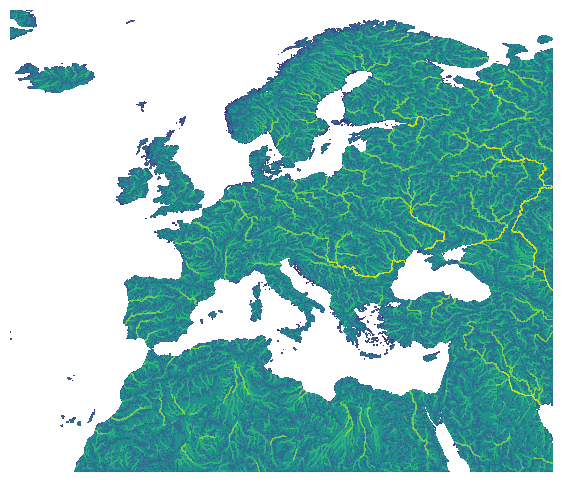

In [5]:
# visualise the results
plot(accuflux_field)

# Subcatchments & Catchments

In [6]:
# create or load the points of interest
points = np.zeros(river_network.mask.shape)
points[1801, 4529] = 5  # largest catchment's sink
points[886, 3999] = 2  # point within largest catchment but not the sink
points[1621, 3298] = 1  # separate catchment

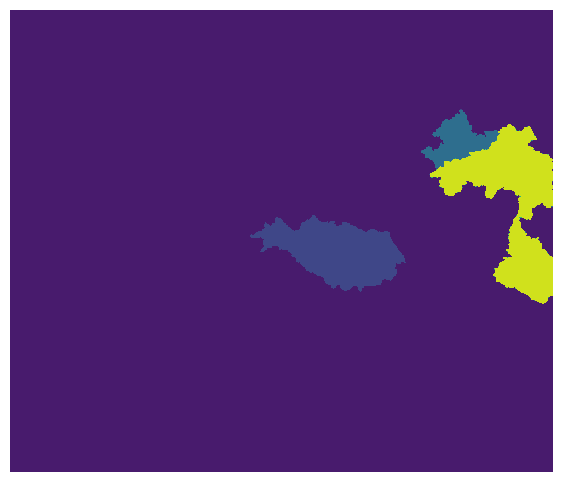

In [7]:
# find and plot the subcatchments
subcatchment_field = ekh.find_subcatchments(river_network, points)

plot(subcatchment_field, norm=None)

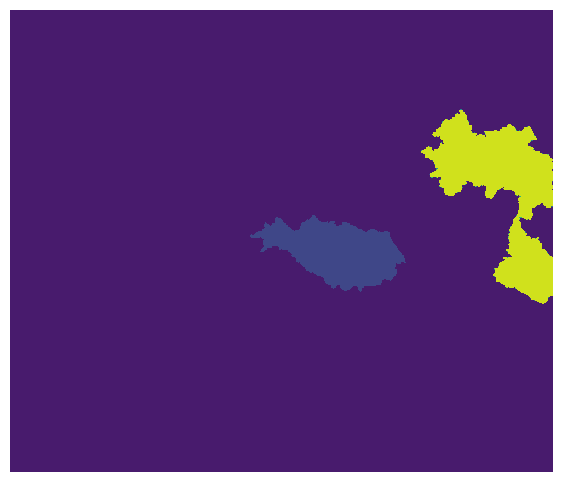

In [8]:
# find and plot the catchments
# note: the subcatchment has been overwritten
catchment_field = ekh.find_catchments(river_network, points)

plot(catchment_field, norm=None)

# Subnetwork

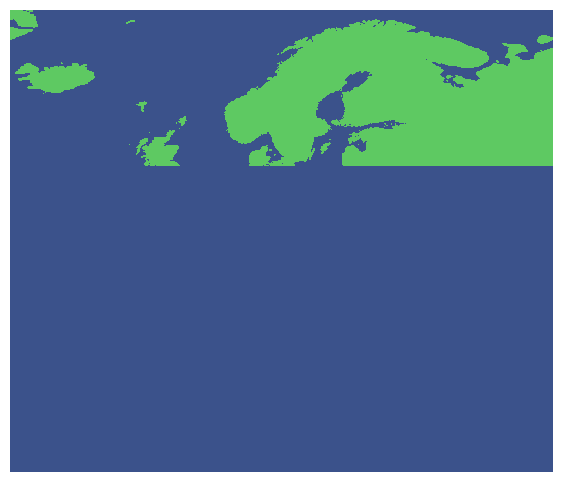

In [9]:
# create a subnetwork given a mask of northern Europe
mask = np.full(river_network.mask.shape, False)
mask[:1000] = True
north_europe_river_network = river_network.create_subnetwork(mask)

plot(north_europe_river_network.mask, norm=None)

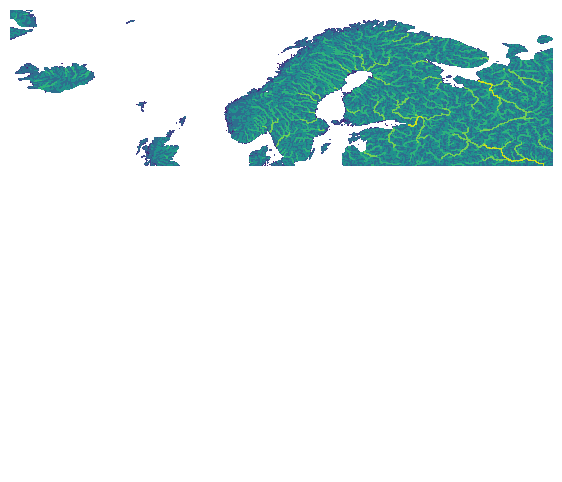

In [10]:
# conduct accuflux on the subnetwork
accuflux_field = ekh.flow_downstream(north_europe_river_network, unit_field)
plot(accuflux_field)

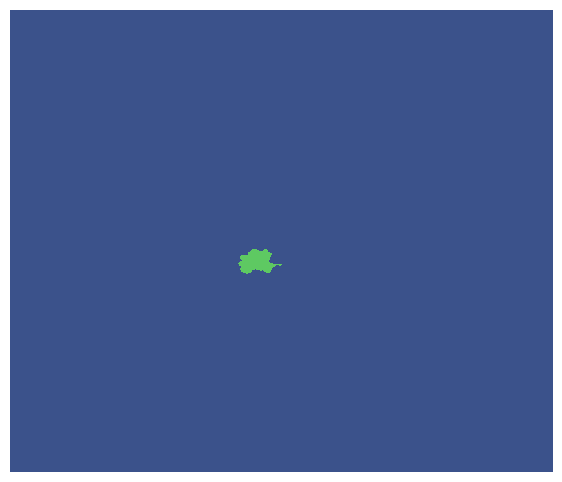

In [11]:
# create a subnetwork of a river catchment
# can find the mask directly by doing catchment with boolean arrays
points = np.full(river_network.mask.shape, False)
points[1636, 2267] = True  # Po river catchment sink
catchment_mask = ekh.find_catchments(river_network, points, mv=False)
po_catchment_network = river_network.create_subnetwork(catchment_mask)
plot(po_catchment_network.mask, norm=None)

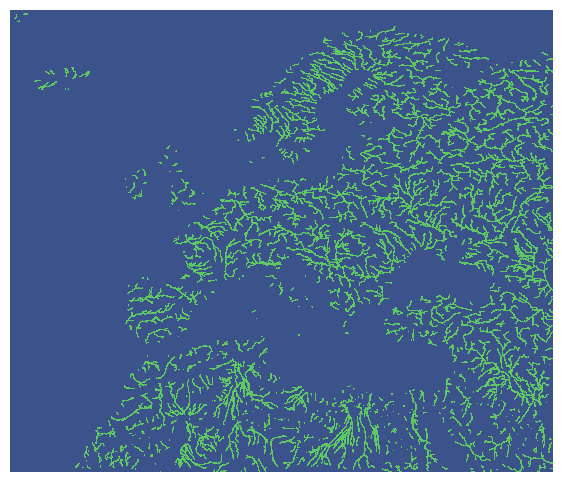

In [12]:
# create a subnetwork of large rivers only
accuflux_field = ekh.flow_downstream(river_network, unit_field)
large_rivers = accuflux_field > 1000
large_river_network = river_network.create_subnetwork(large_rivers)
plot(large_river_network.mask, norm=None)

# Upstream & Downstream

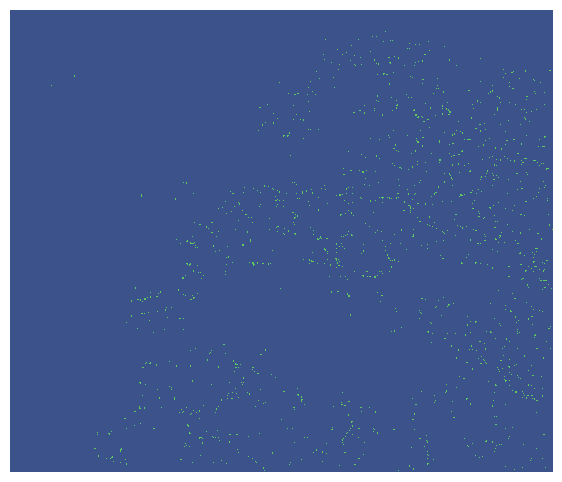

In [13]:
# find confluences of the large rivers
upstream_field = ekh.move_downstream(large_river_network, unit_field)
plot(upstream_field > 1, norm=None)

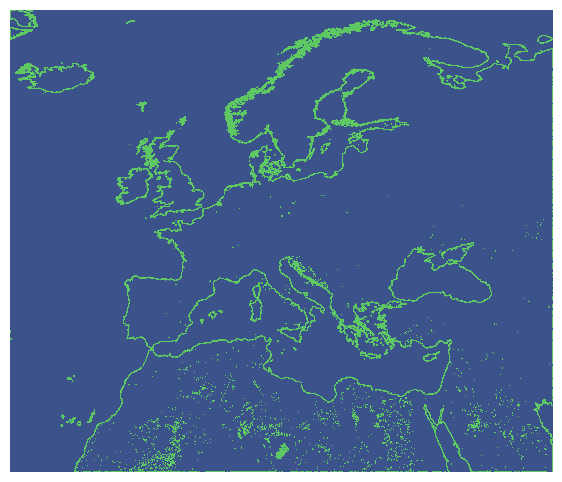

In [14]:
# find sinks of the original river network
downstream_field = ekh.move_upstream(river_network, unit_field)
plot(downstream_field == 0, norm=None)

# Example with Earthkit and Precipitation Maps

In [ ]:
style = ekp.styles.Style(
    colors="Blues",
    levels=[0, 0.5, 1, 2, 5, 10, 50, 100, 500, 1000, 2000, 3000, 4000],
    extend="max",
)

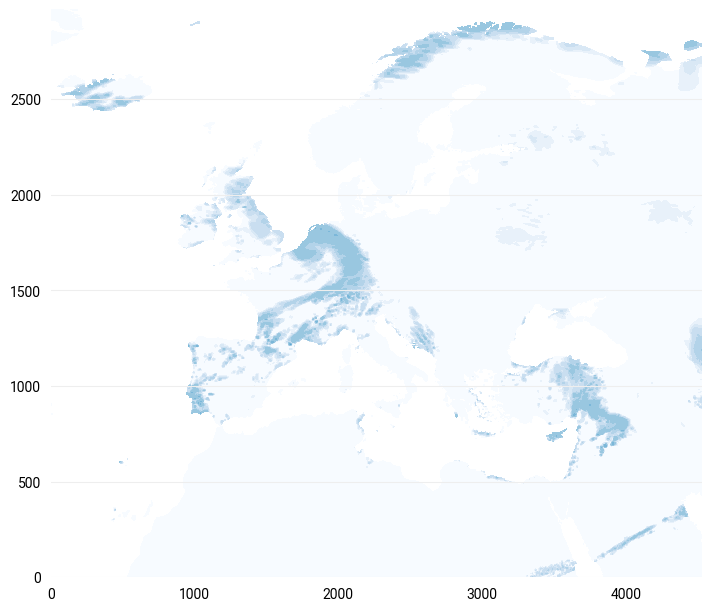

In [16]:
precipitation_field = ekd.from_source(
    "file", "/ec/ws4/tc/emos/work/cems/floods/efas/emos/efas/europe5km/202502/EUD2025021100/forcings/R06a.nc"
)[0].to_numpy()

qplot.contourf(precipitation_field[::-1, :], style=style)

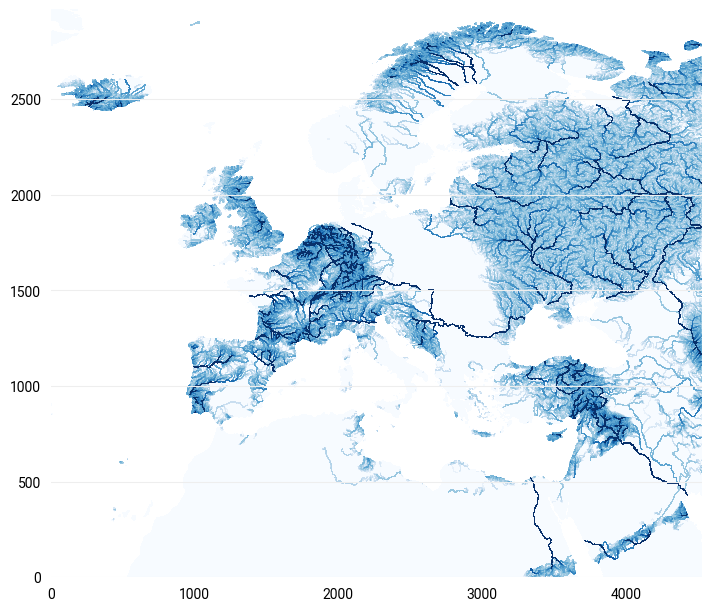

In [17]:
accuflux_field = ekh.flow_downstream(river_network, precipitation_field)
qplot.contourf(accuflux_field[::-1, :], style=style)